In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
torch.cuda.set_device(1)
import skimage.io as io
import tqdm
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
path=Path('/home/staff/xin/Downloads/leafdisease/test/')

In [13]:
src=ImageList.from_folder(path).split_by_rand_pct(seed=2).label_from_folder()

In [14]:
data=(src.transform(get_transforms(),size=224).databunch(bs=4).normalize(imagenet_stats))

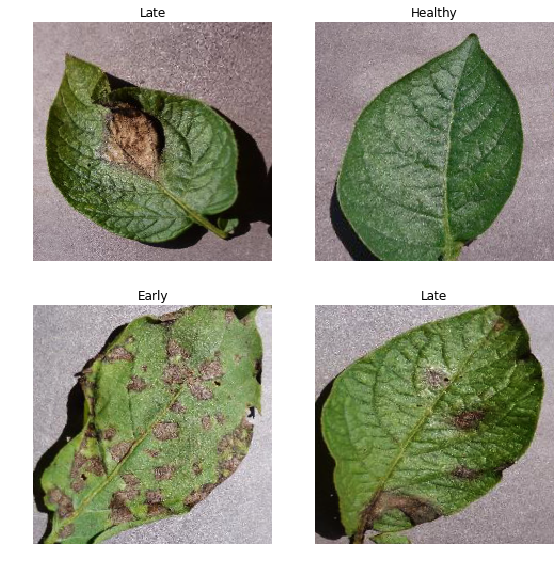

In [15]:
data.show_batch()

In [16]:
arch=models.resnet50(pretrained=True)

In [17]:

class Attention(nn.Module):

    def __init__(self,model):
        '''
        initialize the unet 
        '''
        super(Attention,self).__init__()
        self.Conv1 =nn.Sequential(
            arch.conv1,
            arch.bn1,
            arch.relu,
            PooledSelfAttention2d(64),
            arch.maxpool
        )
        self.Conv2 =arch.layer1
        self.Conv3=arch.layer2
        self.Conv4=arch.layer3
        self.Conv5=arch.layer4
        self.avgpool1 = arch.avgpool
        self.att1=PooledSelfAttention2d(256)
#         self.att2=PooledSelfAttention2d(512)
#         self.att3=PooledSelfAttention2d(1024)
#         self.att4=PooledSelfAttention2d(2048)
#         self.att5=PooledSelfAttention2d(512)
        self.classifier = nn.Linear(2048,38,bias=True)
    def forward(self,x):
#         batch_size = x.size()[0]
        con1=self.Conv1(x)
        con1=self.Conv2(con1)
        con1=self.att1(con1)
        con1=self.Conv3(con1)
#         con1=self.att2(con1)
        con1=self.Conv4(con1)
#         con1=self.att3(con1)
        con1=self.Conv5(con1)
#         print(con1.shape)
#         con1=self.att4(con1)
        output=self.avgpool1(con1)
        output = output.reshape(output.size(0), -1)
        output=self.classifier(output)
        return output

In [177]:
import tensorwatch as tw

In [18]:
gc.collect()
learn=None
model=None

In [19]:
learn=Learner(data,model=Attention(arch),metrics=accuracy).to_fp16()

In [180]:
# learn=learn.split(split_model_idx(learn.model,[24]))

In [181]:
import tensorwatch as tw

In [182]:
learn.freeze()

AssertionError: 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


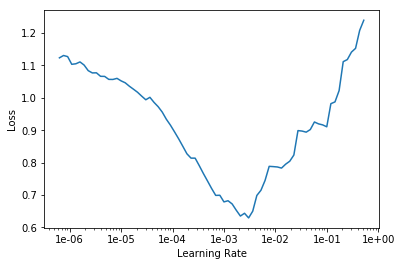

In [133]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5,slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.489707,0.165408,0.941315,00:38
1,0.460097,0.196867,0.936620,00:40
2,0.346467,0.224215,0.910798,00:39
3,0.115581,0.044041,0.981221,00:40
4,0.036050,0.017699,0.997653,00:40


In [159]:
learn.save('resnetatt')

In [169]:
learn.load('resnetatt')

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


RuntimeError: Error(s) in loading state_dict for Attention:
	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 2048]) from checkpoint, the shape in current model is torch.Size([38, 2048]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([38]).

# Grad CAM

In [134]:
from fastai.callbacks.hooks import *

In [167]:
learn.data.get_label_cls

TypeError: get_label_cls() missing 1 required positional argument: 'labels'

In [21]:
i=np.random.randint(1705)
test=data.train_ds[i]
sz = list(test[0].shape[-2:])

In [22]:
xb,_ = data.one_item(test[0], detach=False, denorm=False)
xb=xb.float()

In [23]:
# m =learn.model.eval().float()
# layer1=m.Conv1[3].o
# layer2=m.att1.o
# layer3=m.att2.o
# layer4=m.att3.o
# with hook_outputs([layer1,layer2,layer3,layer4]) as hook_a:
#     preds = m(xb)

In [24]:
test[1].data

0

In [25]:
m =learn.model.eval().float()
layer1=m.Conv1[3].o
with hook_output(layer1) as hook_a: 
    with hook_output(layer1, grad=True) as hook_g:
        preds = m(xb)
        preds[0,test[1].data].backward()


In [26]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
acts  = hook_a.stored[0].cpu()
print(grad_chan.shape,acts.shape)
mult = (acts*grad_chan[...,None,None]).mean(0)

torch.Size([64]) torch.Size([64, 112, 112])


In [27]:
# mult = acts[grad_chan.argmax()]

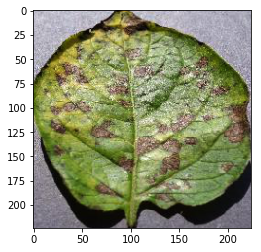

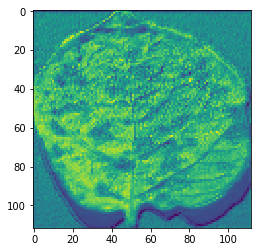

In [29]:
plt.imshow(test[0].data.numpy().transpose(1,2,0))
plt.show()
plt.imshow(mult)

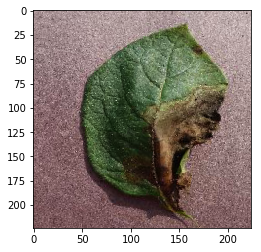

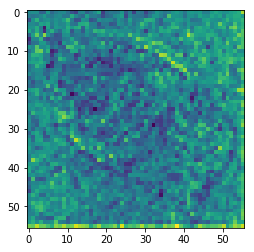

In [72]:
plt.imshow(hook_a.stored.mean(1)[0])

In [76]:
m =learn.model.eval().float()
layer=m.attention2
with hook_output(layer) as hook_a:
    preds = m(xb)
    acts = hook_a.stored[1].cpu()
layer=m.avgpool1
with hook_output(layer) as hook_a:
    with hook_output(layer, grad= True) as hook_g:
        preds = m(xb)
        preds[0,test[1].data].backward()
acts2 = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
mult = F.relu(((acts2*grad_chan[...,None,None])).sum(0))

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


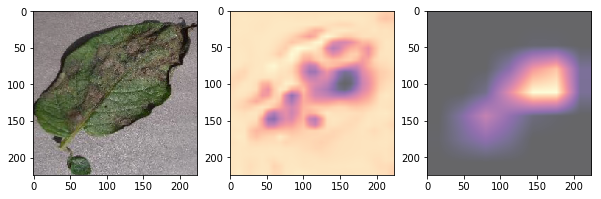

In [79]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(test[0].data.numpy().transpose(1,2,0))
# plt.imshow(acts[0,0]>0.2, alpha=0.2, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
# plt.imshow(acts[0,0], alpha=0.2, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
plt.subplot(132)
plt.imshow(acts[0,0], alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
plt.subplot(133)
plt.imshow(mult, alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')

In [61]:
m =learn.model.eval().float()
layer=m.avgpool


AttributeError: 'Attention' object has no attribute 'avgpool'

# Lime